### **Amazon Example for Class**

![](https://images-eu.ssl-images-amazon.com/images/G/30/Consumables/Beauty/2023/header.png)

**Librerías**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

#### **0. EDA**

* Dependiendo del objetivo del sistema de recomendación los quitamos o no 
  * Long tail. ¿Hasta cuando nos compensa quitar información?
  * En este caso sería un outlier de Rating
  * En terminos del outlier, debemos de analizar el Rating, por lo tanto es un análisis de usuarios, no de los productos. 

Box-plot - 12-13% de ratings
Dependiendo del histograma, me va a ayudar esto a montar o no distintos perfiles? Justificalo
Recomendado recortar el # de datos a 10.000 de manera aleatoria. 

In [2]:
df_path = "./ratings_Beauty.csv"
amazon_ratings = pd.read_csv(df_path, header=0)

In [3]:
amazon_ratings.shape
amazon_ratings_sample = amazon_ratings.sample(n=10000, random_state=42)
amazon_ratings = amazon_ratings_sample

In [4]:
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
1909529,A2IL3S5JIMVU7G,B00DHG3KRY,5.0,1386979200
1602242,A33VGZOMZUOOG8,B007RNPAJO,1.0,1378512000
1181425,A3H1D1D0G80ZWA,B0047L3FRS,5.0,1367280000
1848825,A26XDAOZFABDKK,B00BNLHUPI,5.0,1372291200
961295,A12QIPKKP0OPOJ,B002ZW1RJY,4.0,1377820800


In [5]:
amazon_ratings.shape

(10000, 4)

In [6]:
unique_users = amazon_ratings["UserId"].nunique()
unique_products = amazon_ratings["ProductId"].nunique()
unique_ratings = amazon_ratings["Rating"].nunique()
ratings_list = sorted(amazon_ratings["Rating"].unique())
print(
    f"Unique users: {unique_users}, Unique products: {unique_products}, Unique ratings: {unique_ratings}"
)
print(f"Ratings given by the users: {ratings_list}")

Unique users: 9879, Unique products: 8152, Unique ratings: 5
Ratings given by the users: [1.0, 2.0, 3.0, 4.0, 5.0]


In [7]:
amazon_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1909529 to 792407
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserId     10000 non-null  object 
 1   ProductId  10000 non-null  object 
 2   Rating     10000 non-null  float64
 3   Timestamp  10000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 390.6+ KB


In [8]:
# * Agrupamos para ver si el número de críticas esta equilibrado
popular_products = pd.DataFrame(amazon_ratings.groupby("ProductId")["Rating"].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,39
B0009V1YR8,15
B0043OYFKU,13
B004INUWX0,13
B000ZMBSPE,13
B001AO0WCG,11
B001JKTTVQ,11
B0000YUXI0,10
B005Y6F4WO,10


**Número de críticas por usuarios**

<Axes: xlabel='ProductId'>

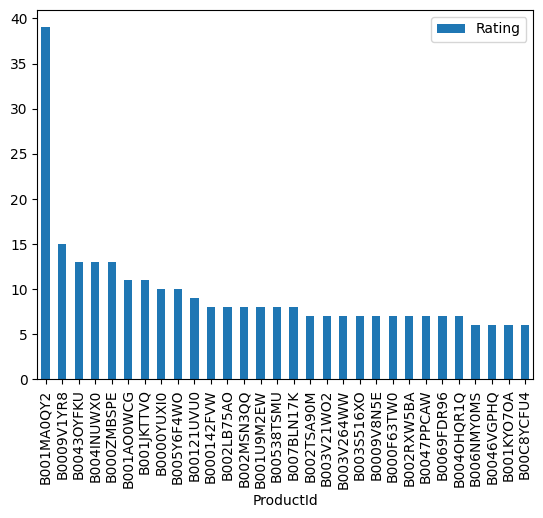

In [9]:
most_popular.head(30).plot(kind="bar")

**Número de críticas por usuario**

In [10]:
# * Agrupamos para ver si el número de críticas esta equilibrado
user_review_count = pd.DataFrame(amazon_ratings.groupby("UserId")["Rating"].count())
most_active_users = user_review_count.sort_values("Rating", ascending=False)
most_active_users.head(10)

,Rating
UserId,
A3KEZLJ59C1JVH,4
A2Y4S4CNGKF21S,4
A3J029KBNG5MNP,3
ALQGOMOY1F5X9,3
A2KJQX0MK4E8GY,2
A260QLS8Z33KCQ,2
A3MRTY6Q0IAWZ2,2
A1R377IPZOKLMM,2
A2394O76GGGTXQ,2


<Axes: xlabel='UserId'>

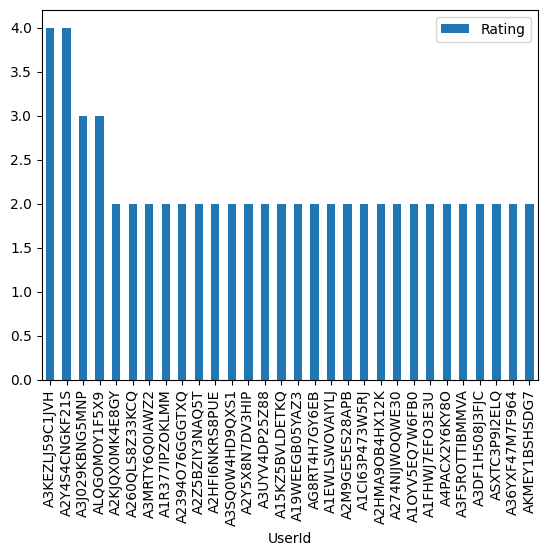

In [11]:
most_active_users.head(30).plot(kind="bar")

**Distribución de críticas de los productos (Rating vs. # de Ratings)**

In [12]:
agg_prod_ratings = (
    amazon_ratings.groupby("ProductId")
    .agg(mean_rating=("Rating", "mean"), number_of_ratings=("Rating", "count"))
    .reset_index()
)
agg_prod_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8152 entries, 0 to 8151
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductId          8152 non-null   object 
 1   mean_rating        8152 non-null   float64
 2   number_of_ratings  8152 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 191.2+ KB


In [13]:
agg_prod_ratings.sort_values(by="number_of_ratings", ascending=False).head()

,ProductId,mean_rating,number_of_ratings
2921,B001MA0QY2,4.307692,39
601,B0009V1YR8,4.133333,15
4619,B0043OYFKU,4.461538,13
4943,B004INUWX0,4.230769,13
1940,B000ZMBSPE,4.923077,13


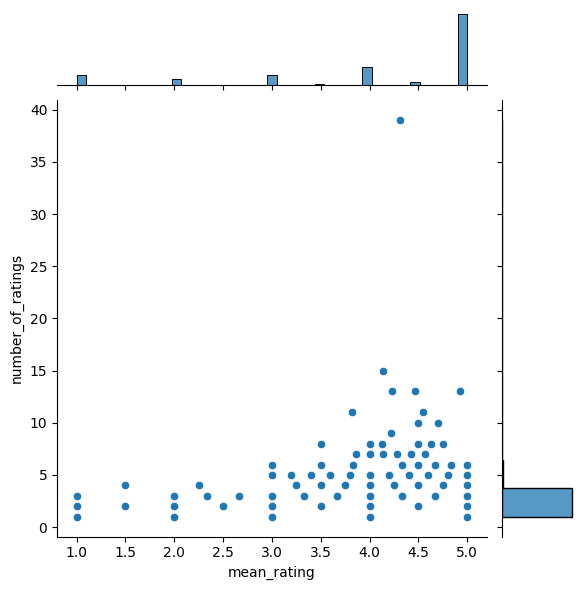

In [14]:
sns.jointplot(x="mean_rating", y="number_of_ratings", data=agg_prod_ratings)

¿Que podemos observar? 

Que cuanto mejor suele ser el producto, más criticas suelen haber. Se observa tambien un claro sesgo de mayor número de críticas a productos que se clasifican como "Mejores"

Cada punto es un producto con su rating medio, y su número. 

**Distribución de usuarios**

Objetivo de observar las tendencias, y como de activos/sesgados son al dar valoraciones

In [15]:
agg_user_ratings = (
    amazon_ratings.groupby("UserId")
    .agg(mean_rating=("Rating", "mean"), number_of_ratings=("Rating", "count"))
    .reset_index()
)
agg_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UserId             9879 non-null   object 
 1   mean_rating        9879 non-null   float64
 2   number_of_ratings  9879 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 231.7+ KB


In [16]:
agg_user_ratings.sort_values(by="number_of_ratings", ascending=False).head()

,UserId,mean_rating,number_of_ratings
6643,A3KEZLJ59C1JVH,3.250000,4
5051,A2Y4S4CNGKF21S,4.500000,4
6556,A3J029KBNG5MNP,3.666667,3
8865,ALQGOMOY1F5X9,1.000000,3
3998,A2KJQX0MK4E8GY,4.000000,2


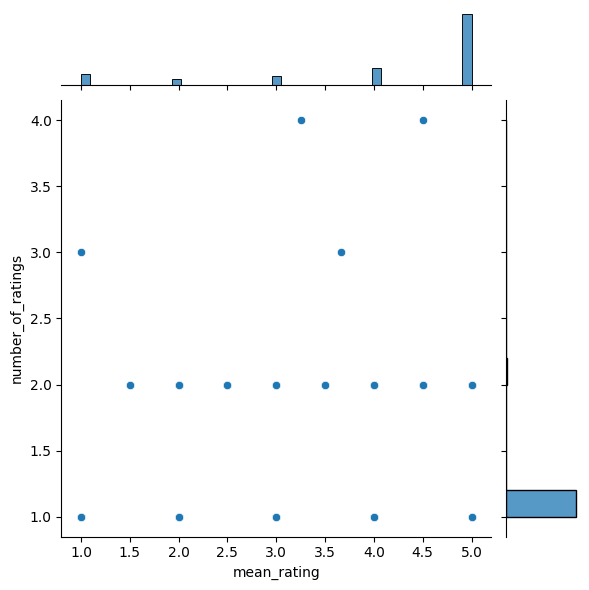

In [17]:
sns.jointplot(x="mean_rating", y="number_of_ratings", data=agg_user_ratings)

¿Que observamos? 

Que hay una tendencia muy alta por parte de los usuarios de puntuar de manera muy alta, lo cual cuadra con la gráfica anterior. Y los usuarios que puntuan, suelen puntuar alto. 

Si nos fijamos en la sección superior, tambien observamos que los usuarios dan puntuación enteras, mas que medias estrellas. 

[comment]: <> (Preguntar sobre esto)
^^Preguntar sobre eso 

### Planificación: 

* Memory-Based []
  * User-Based (Mediante Pearson / Cosine) []
  * Item-Based (Mediante Pearson / Adjusted Cosine) []
* Model-Based
  * Singular Value Decomp []
  * Matrix Factorisation []

Hazte dos pandaframes para cada sistema de recomendación respectivo. 

In [18]:
user_matrix = amazon_ratings.pivot_table(
    index="UserId", columns="ProductId", values="Rating", fill_value=0
)
user_matrix.head()

ProductId,9571044822,9602617918,9788072992,9790779968,9790781210,9790790988,9790798911,9944260118,B00004TMFE,B00004TUBL,...,B00KQBR9FM,B00KQWBJ5W,B00KTLBEEQ,B00KUWDWO4,B00KWE08Q0,B00KWFDBKE,B00L2KVF9W,B00L31Z15E,B00L5KTZ0K,B00LBEXC3Q
UserId,,,,,,,,,,,,,,,,,,,,,
A004205218STRNUW6PPPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00540051HYJDHVJB2FRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01198201H0E3GHV2Z17I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0126073315N22OLC73MZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
product_matrix = user_matrix.T
product_matrix.head()

UserId,A004205218STRNUW6PPPA,A00473363TJ8YSZ3YAGG9,A00540051HYJDHVJB2FRO,A01198201H0E3GHV2Z17I,A0126073315N22OLC73MZ,A035495739MKWSR6Z6TVK,A05483202XOXLA2PPHE2I,A06499133GHSDTC5DSCC5,A08202043ESQMBAPGA1SQ,A0903581294IP0V6FDJK9,...,AZTXVELITLCI4,AZTYMMD36CXY2,AZU4L050B0ADX,AZUHYH6FWFOWA,AZV7CNMMJERKW,AZV8DUIDD7Z46,AZVKC5S1BCBNU,AZVKJAGD4GISS,AZXC4VH7CHFXR,AZYM7TVEU0NM
ProductId,,,,,,,,,,,,,,,,,,,,,
9571044822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9602617918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9788072992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9790779968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9790781210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **1. User-based recommendation**

User profiling function -> Pasale el userID y que te devuelva las 5 primeras recomendaciones -> Objetivo final

**Al formar la Pivot Table, tiene sentido rellenar los NA's con 0, ya que no se le puede dar un rating vacío a un producto. Debe de ser mayor a 0.**

Como hemos observado en las gráficas anteriores, hay muchos usuarios que dan una puntuación más alta que las anteriores, por lo tanto debemos de normalizar la puntuación dada, para extraer la puntuación media que da cada usuario.

In [20]:
user_matrix_norm = user_matrix.subtract(user_matrix.mean(axis=1))
user_matrix_norm

,9571044822,9602617918,9788072992,9790779968,9790781210,9790790988,9790798911,9944260118,A004205218STRNUW6PPPA,A00473363TJ8YSZ3YAGG9,...,B00KQBR9FM,B00KQWBJ5W,B00KTLBEEQ,B00KUWDWO4,B00KWE08Q0,B00KWFDBKE,B00L2KVF9W,B00L31Z15E,B00L5KTZ0K,B00LBEXC3Q
UserId,,,,,,,,,,,,,,,,,,,,,
A004205218STRNUW6PPPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00540051HYJDHVJB2FRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A01198201H0E3GHV2Z17I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0126073315N22OLC73MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZV8DUIDD7Z46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZVKC5S1BCBNU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZVKJAGD4GISS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2 maneras de comparar la similitud de usuarios: 
Primero mediante Pearson, y después mediante cosine similarity. 

In [21]:
user_sim_pearson = user_matrix_norm.T.corr()
user_sim_pearson.head()

In [ ]:
def user_recommendation(user_id):
    pass
    # * Pseudo-code time

#### **2. Item-based**

#### **3. Model-Based**

**3.1 SVD**

**3.2. Matrix Factorisation**

**3.3 KMeans for any model**

#### **4. Conclusions and Comparisons**